In [15]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


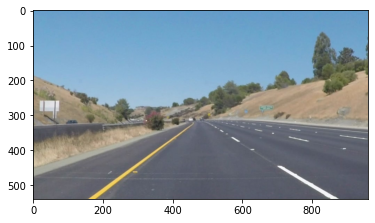

In [16]:
#reading in an image
#image = mpimg.imread('solidWhiteRight.jpg')
image = mpimg.imread('P1_test_images/solidYellowCurve2.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [17]:
x_left = []
y_left = []
x_right = []
y_right = []

In [18]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    x_size = img.shape[1]
    y_size = img.shape[0]
    count = 0
    x = 0
    for line in lines:
        for x1,y1,x2,y2 in line:            
            if (((y2 - y1) == 0) and (x2 - x1) == 0): 
                print(x1,y1,x2,y2)
                continue
            m = (y2 - y1)/(x2 - x1)
            if(np.isnan(float(m))):                                
                continue            
            if(m > 0):
                x_right.append(x1)
                y_right.append(y1)
                x_right.append(x2)
                y_right.append(y2)
            elif m < 0:
                x_left.append(x1)
                y_left.append(y1)
                x_left.append(x2)
                y_left.append(y2)
    if len(x_left) == 0:
      print("Your x_left array is empty")
    if len(x_right) == 0:
      print("Your x_right array is empty")
    print(count)
    left_lane= np.polyfit(x_left,y_left,1)
    right_lane= np.polyfit(x_right,y_right,1)
    cv2.line(img, (min(x_left), min(y_left)), (max(x_left), max(y_left)), (255, 0, 0), 10)
    cv2.line(img, (min(x_right), min(y_right)), (max(x_right), max(y_right)), (255, 0, 0), 10)
'''
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)         
'''
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

0
(540, 960)
(540, 960, 3)


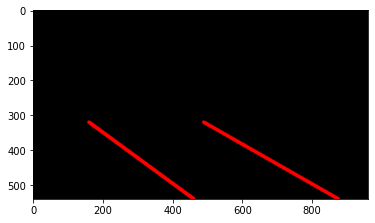

In [19]:
gray = grayscale(image)
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 100
edges = canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()  

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)

masked_edges = region_of_interest(edges, vertices)
#plt.imshow(masked_edges, cmap = 'gray')

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50   # minimum number of votes (intersections in Hough grid cell)
min_line_length = 1 #minimum number of pixels making up a line
max_line_gap = 250   # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines_img = hough_lines(masked_edges, rho, theta, threshold,
                            min_line_length, max_line_gap)

'''
# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
'''

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
plt.imshow(color_edges, cmap = 'gray')
print(edges.shape)
print(color_edges.shape)

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_img)

True

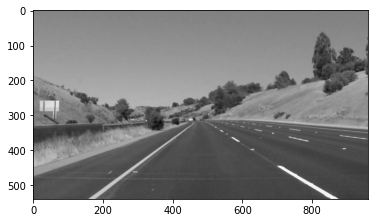

In [20]:
plt.imshow(gray,cmap='gray')
cv2.imwrite('test_images_output/gray.jpg', gray)

True

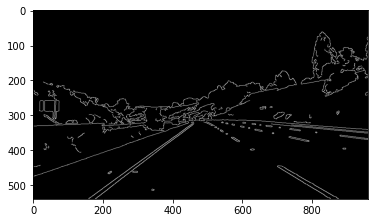

In [21]:
plt.imshow(edges,cmap='gray')
cv2.imwrite('test_images_output/edges.jpg', edges)

True

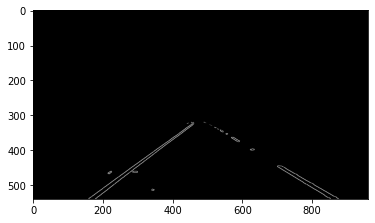

In [22]:
plt.imshow(masked_edges,cmap='gray')
cv2.imwrite('test_images_output/edges.jpg', masked_edges)

True

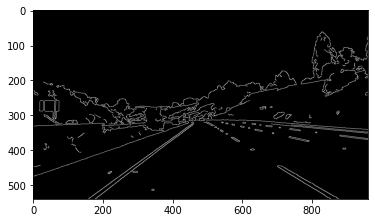

In [23]:
plt.imshow(color_edges)
cv2.imwrite('test_images_output/edges.jpg', color_edges)

In [24]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
def process_image(image):

    # grayscale conversion before processing causes more harm than good
    # because sometimes the lane and road have same amount of luminance
    # grayscaleImage = grayscale(image)

    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 5)
    
    # Detect edges using canny
    # high to low threshold factor of 3
    # it is necessary to keep a linient threshold at the lower end
    # to continue to detect faded lane markings
    edgesImage = canny(blurredImage, 50, 100)
    
    # mark out the trapezium region of interest
    # dont' be too agressive as the car may drift laterally
    # while driving, hence ample space is still left on both sides.
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # mask the canny output with trapezium region of interest
    regionInterestImage = region_of_interest(edgesImage, vertices)
    
    # parameters tuned using this method:
    # threshold 30 by modifying it and seeing where slightly curved 
    # lane markings are barely detected
    # min line length 20 by modifying and seeing where broken short
    # lane markings are barely detected
    # max line gap as 100 to allow plenty of room for the algo to 
    # connect spaced out lane markings
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 50, 100, 160)
    
    # Test detected edges by uncommenting this
    # return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

    # draw output on top of original
    return weighted_img(lineMarkedImage, image)

0


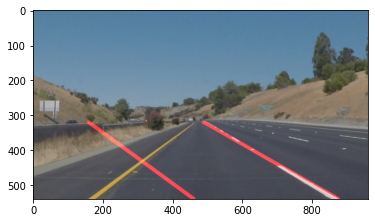

In [25]:
out_image = process_image(image)
#plt.imshow(out_image)
plt.imshow(out_image, cmap = 'gray')

In [26]:
#Testing on videos
#Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
def process_image(image):

    # grayscale conversion before processing causes more harm than good
    # because sometimes the lane and road have same amount of luminance
    # grayscaleImage = grayscale(image)

    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 5)
    
    # Detect edges using canny
    # high to low threshold factor of 3
    # it is necessary to keep a linient threshold at the lower end
    # to continue to detect faded lane markings
    edgesImage = canny(blurredImage, 50, 100)
    
    # mark out the trapezium region of interest
    # dont' be too agressive as the car may drift laterally
    # while driving, hence ample space is still left on both sides.
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # mask the canny output with trapezium region of interest
    regionInterestImage = region_of_interest(edgesImage, vertices)
    
    # parameters tuned using this method:
    # threshold 30 by modifying it and seeing where slightly curved 
    # lane markings are barely detected
    # min line length 20 by modifying and seeing where broken short
    # lane markings are barely detected
    # max line gap as 100 to allow plenty of room for the algo to 
    # connect spaced out lane markings
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 50, 100, 160)
    
    # Test detected edges by uncommenting this
    # return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

    # draw output on top of original
    return weighted_img(lineMarkedImage, image)



In [28]:
white_output = 'P1_test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("P1_test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

0
Moviepy - Building video P1_test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video P1_test_videos_output/solidWhiteRight.mp4

0


t:   1%|▌                                                                    | 2/221 [00:00<00:27,  8.11it/s, now=None]

0


t:   3%|█▊                                                                   | 6/221 [00:06<04:37,  1.29s/it, now=None]

0
0
0
0
0
0
0

t:   6%|████▎                                                               | 14/221 [00:06<02:14,  1.54it/s, now=None]


0
0
0
0
0


t:  10%|██████▍                                                             | 21/221 [00:06<01:07,  2.98it/s, now=None]

0
0
0
0
0
0
0

t:  11%|███████▋                                                            | 25/221 [00:06<00:47,  4.11it/s, now=None]


0
0
0
0
0
0

t:  14%|█████████▊                                                          | 32/221 [00:07<00:26,  7.25it/s, now=None]


0
0
0
0
0
0

t:  16%|███████████                                                         | 36/221 [00:07<00:19,  9.43it/s, now=None]


0
0
0
0
0
0

t:  19%|█████████████▏                                                      | 43/221 [00:07<00:12, 14.25it/s, now=None]


0
0
0
0
0

t:  21%|██████████████▏                                                     | 46/221 [00:07<00:10, 16.44it/s, now=None]


0
0
0


t:  24%|████████████████                                                    | 52/221 [00:07<00:09, 18.03it/s, now=None]

0
0
0
0
0
0
0

t:  26%|█████████████████▊                                                  | 58/221 [00:08<00:07, 22.07it/s, now=None]


0
0
0
0
0


t:  29%|████████████████████                                                | 65/221 [00:08<00:06, 25.33it/s, now=None]

0
0
0
0
0
0


t:  31%|████████████████████▉                                               | 68/221 [00:08<00:05, 26.12it/s, now=None]

0
0
0
0
0
0


t:  35%|████████████████████████                                            | 78/221 [00:08<00:05, 27.38it/s, now=None]

0
0
0
0
0
0
0

t:  37%|█████████████████████████▏                                          | 82/221 [00:08<00:04, 28.16it/s, now=None]


0
0
0
0
0


t:  40%|███████████████████████████                                         | 88/221 [00:09<00:04, 28.10it/s, now=None]

0
0
0
0
0
0


t:  43%|█████████████████████████████▏                                      | 95/221 [00:09<00:04, 28.23it/s, now=None]

0
0
0
0
0
0


t:  46%|██████████████████████████████▌                                    | 101/221 [00:09<00:04, 27.89it/s, now=None]

0
0
0
0
0
0


t:  49%|████████████████████████████████▋                                  | 108/221 [00:09<00:03, 29.12it/s, now=None]

0
0
0
0
0
0


t:  50%|█████████████████████████████████▋                                 | 111/221 [00:09<00:03, 28.45it/s, now=None]

0
0
0
0
0
0


t:  53%|███████████████████████████████████▊                               | 118/221 [00:10<00:03, 28.80it/s, now=None]

0
0
0
0
0
0
0

t:  57%|█████████████████████████████████████▉                             | 125/221 [00:10<00:03, 29.29it/s, now=None]


0
0
0
0
0

t:  58%|██████████████████████████████████████▊                            | 128/221 [00:10<00:03, 28.22it/s, now=None]


0
0
0
0
0
0

t:  62%|█████████████████████████████████████████▏                         | 136/221 [00:10<00:02, 29.12it/s, now=None]


0
0
0
0
0


t:  63%|██████████████████████████████████████████▏                        | 139/221 [00:10<00:02, 28.20it/s, now=None]

0
0
0
0
0
0


t:  66%|████████████████████████████████████████████▎                      | 146/221 [00:11<00:02, 28.32it/s, now=None]

0
0
0
0
0
0
0


t:  70%|██████████████████████████████████████████████▋                    | 154/221 [00:11<00:02, 31.01it/s, now=None]

0
0
0
0
0
0


t:  71%|███████████████████████████████████████████████▉                   | 158/221 [00:11<00:02, 30.46it/s, now=None]

0
0
0
0
0
0


t:  75%|██████████████████████████████████████████████████▎                | 166/221 [00:11<00:01, 30.17it/s, now=None]

0
0
0
0
0
0
0

t:  79%|████████████████████████████████████████████████████▊              | 174/221 [00:12<00:01, 30.52it/s, now=None]


0
0
0
0
0
0
0

t:  81%|█████████████████████████████████████████████████████▉             | 178/221 [00:12<00:01, 31.14it/s, now=None]


0
0
0
0
0
0

t:  84%|████████████████████████████████████████████████████████▍          | 186/221 [00:12<00:01, 30.10it/s, now=None]


0
0
0
0
0
0

t:  86%|█████████████████████████████████████████████████████████▌         | 190/221 [00:12<00:01, 30.24it/s, now=None]


0
0
0
0
0
0

t:  90%|████████████████████████████████████████████████████████████       | 198/221 [00:12<00:00, 29.71it/s, now=None]


0
0
0
0
0
0

t:  91%|█████████████████████████████████████████████████████████████▏     | 202/221 [00:12<00:00, 29.90it/s, now=None]


0
0
0
0
0
0

t:  95%|███████████████████████████████████████████████████████████████▋   | 210/221 [00:13<00:00, 29.89it/s, now=None]


0
0
0
0
0
0

t:  98%|█████████████████████████████████████████████████████████████████▍ | 216/221 [00:13<00:00, 28.51it/s, now=None]


0
0
0
0
0


0
0
0
0
0


Moviepy - Done !
Moviepy - video ready P1_test_videos_output/solidWhiteRight.mp4


In [75]:
white_output = 'P1_test_videos_output/challenge.mp4'
clip1 = VideoFileClip("P1_test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                             | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video P1_test_videos_output/challenge.mp4.
Moviepy - Writing video P1_test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready P1_test_videos_output/challenge.mp4
